# EDA 
EDA goals are:
- Perfom data quality checks, such as missing values, duplicates.
- Understand data types.
- Understand data distributions(descriptive metrics, outliers, data balance).
- Understand what data preprecesing steps to take before modeling.

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from sklearn.preprocessing import StandardScaler
import re
from utils import extract_number

In [2]:
# Define the path to your Parquet file or directory
dataPath = "data.parquet"  
# Read the Parquet data into a DataFrame
df = pd.read_parquet(dataPath)

In [4]:
df.head()

,col_0_numeric,col_1_numeric,col_2_numeric,col_3_numeric,col_4_numeric,col_5_numeric,col_6_numeric,col_7_numeric,col_8_numeric,col_9_numeric,...,col_318_numeric,col_319_numeric,col_320_numeric,col_321_numeric,col_322_numeric,col_323_numeric,col_324_numeric,col_325_numeric,label,col_327_other
0,270.983551,40.060154,NaN,NaN,0.476529,0.131972,NaN,NaN,NaN,NaN,...,NaN,21.428572,7.142857,0.0,NaN,NaN,258.870544,NaN,Continue,2024-04-28 02:04:00.944030
1,NaN,7.867676,NaN,NaN,17.629303,26.530045,NaN,NaN,NaN,NaN,...,64.812294,85.714287,78.571426,0.0,-2.163792,80.260124,-151.599518,53.983444,Continue,2024-04-28 02:12:55.364655
2,NaN,7.867676,NaN,NaN,17.629303,26.530045,NaN,NaN,25.218269,96.353047,...,64.812294,85.714287,78.571426,0.0,-2.163792,80.260124,-151.599518,53.983444,Continue,2024-04-28 02:12:55.364655
3,NaN,7.867676,NaN,NaN,17.629303,26.530045,NaN,NaN,828.416504,1989.064141,...,64.812294,85.714287,78.571426,0.0,-2.163792,80.260124,-151.599518,53.983444,Continue,2024-04-28 02:12:55.364655
4,NaN,7.867676,NaN,NaN,17.629303,26.530045,NaN,NaN,71.380898,300.839694,...,64.812294,85.714287,78.571426,0.0,-2.163792,80.260124,-151.599518,53.983444,Continue,2024-04-28 02:12:55.364655


In [5]:
# Check data size
df.shape

(11533904, 328)

In [18]:
# Check data balance
df.label.value_counts() / df.shape[0]

label
Continue       0.98555
Interrupted    0.01445
Name: count, dtype: float64

In [5]:
# Check data types
df.dtypes.value_counts()

float32           208
float64           115
int64               2
category            1
object              1
datetime64[us]      1
Name: count, dtype: int64

In [4]:
# 
# Display non-numerical attributes
df.select_dtypes(include=["int64", "category", "object"]).head(15)

,col_14_other,col_15_string,col_16_string,label
0,ap-south-1,0,0,Continue
1,us-west-2,1,1,Continue
2,us-west-2,2,2,Continue
3,us-west-2,3,3,Continue
4,us-west-2,4,4,Continue
5,us-west-2,5,5,Continue
6,us-west-2,4,4,Continue
7,us-west-2,4,4,Continue
8,us-west-2,6,6,Continue
9,us-west-2,7,7,Continue


In [19]:
# Check if values are unique
len(df.col_16_string.value_counts())

1854

In [20]:
len(df.col_15_string.value_counts())

602

In [3]:
# Aggegate timestamps to minutes to clean the data from duplicates by subset
df["timestamp_rounded"] = df["col_327_other"].dt.round("min")
df_clean0 = df.drop(["col_327_other"], axis=1).drop_duplicates(
    subset=[
        "timestamp_rounded",
        "label",
        "col_14_other",
        "col_15_string",
        "col_16_string",
    ]
)
df_clean0.shape

(1282844, 328)

In [6]:
# Check how much data is left after cleaning in %
df_clean0.shape[0] / df.shape[0]

0.1112237452297158

In [35]:
# Check imbalance after cleaning
df_clean0.label.value_counts() / df_clean0.shape[0]

label
Continue       0.935907
Interrupted    0.064093
Name: count, dtype: float64

In [7]:
# Normalise data for distributions check
scaler = StandardScaler()
numeric_df = df_clean0.select_dtypes(include=["int64", "float64", "float32"])
scaled_features = scaler.fit_transform(numeric_df)

In [8]:
scaled_df = pd.DataFrame(scaled_features, columns=numeric_df.columns, index=numeric_df.index)
df_stats = scaled_df.describe()

In [12]:
# Analise missing values to check if some attributes have missings just for Interrupted events
missing_values_per_column = df_clean0.isnull().sum() / df_clean0.shape[0]

In [33]:
max(missing_values_per_column)

0.9942853534802361

<Axes: >

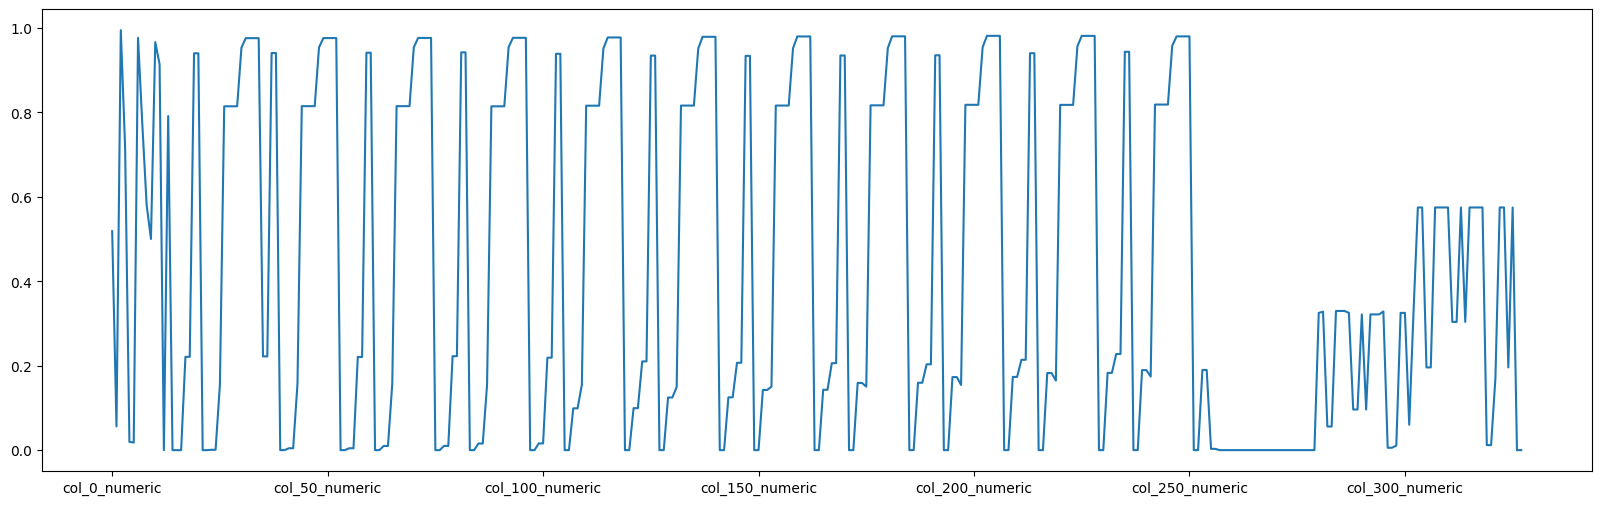

In [13]:
missing_values_per_column.plot(kind="line", figsize=(20, 6))

<Axes: >

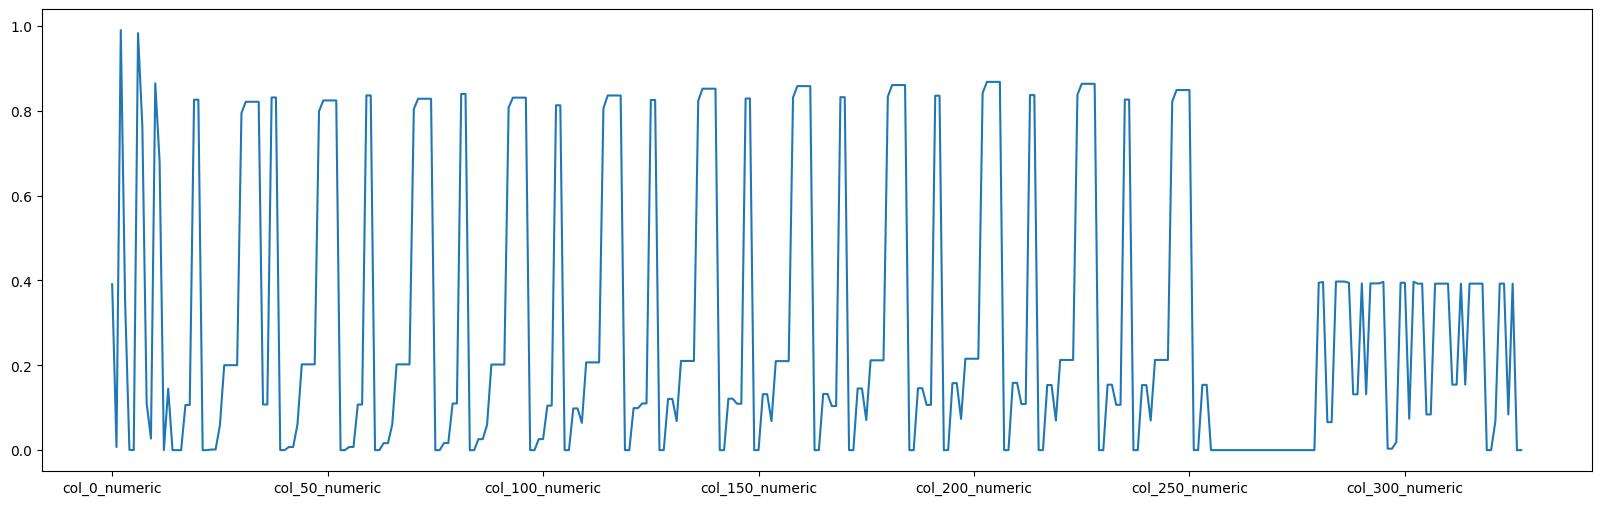

In [15]:
df_interrupted = df_clean0[df_clean0["label"] == "Interrupted"]
df_interrupted_missings = df_interrupted.isnull().sum() / df_interrupted.shape[0]
df_interrupted_missings.plot(kind="line", figsize=(20, 6))

In [16]:
df_continue = df_clean0[df_clean0["label"] == "Continue"]
df_continue_missings = df_continue.isnull().sum() / df_continue.shape[0]
df_diff_missings = df_continue_missings - df_interrupted_missings

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(-50.0, 0, 'col_216_numeric'),
  Text(0.0, 0, 'col_13_numeric'),
  Text(50.0, 0, 'col_310_numeric'),
  Text(100.0, 0, 'col_138_numeric'),
  Text(150.0, 0, 'col_59_numeric'),
  Text(200.0, 0, 'col_187_numeric'),
  Text(250.0, 0, 'col_98_numeric'),
  Text(300.0, 0, 'col_78_numeric'),
  Text(350.0, 0, '')])

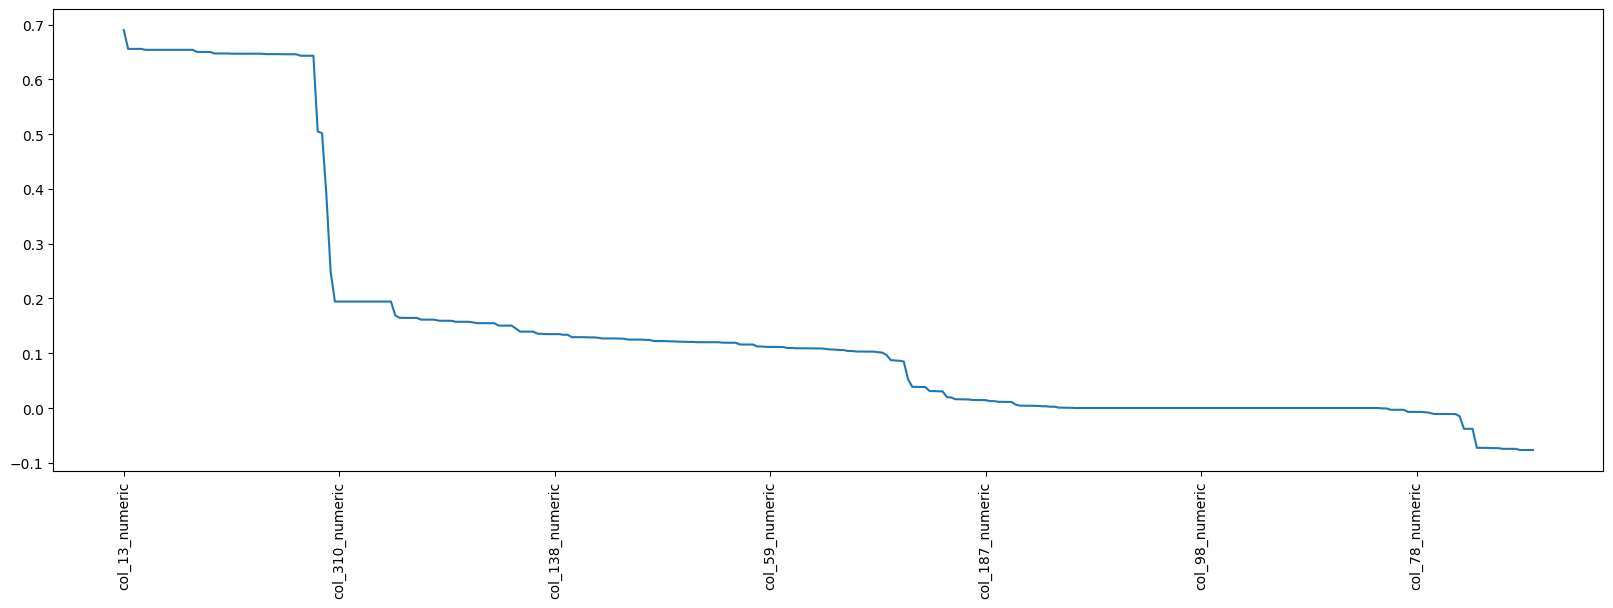

In [21]:
df_diff_missings.sort_values(ascending=False).plot(kind="line", figsize=(20, 6))
# ax.set_xticks(list(df_diff_missings.index))
# ax.set_xticklabels(df_diff_missings.index, rotation=90)
plt.xticks(rotation=90)

In [10]:
# Extract the numbers from the column names and create a new dictionary
new_column_names = {col: extract_number(col) for col in df_stats.columns}
# Rename the columns
df_stats.rename(columns=new_column_names, inplace=True)

NameError: name 'df_stats' is not defined

In [53]:
df_stats_t = (
    pd.DataFrame(df_stats)
    .drop(columns=[col for col in df_stats.columns if pd.isna(col)], axis=1)
    .T.drop(["count", "max"], axis=1)
    .sort_values(["mean", "50%"], ascending=False)
)

In [63]:
def plot_multiple_lines(
    data:pd.DataFrame,
    x_col:List,
    y_cols:List,
    title:str="Multiple Line Plot",
    xlabel:str="X-axis",
    ylabel:str="Y-axis",
    rotation:int=45,
)->None:
    """
    Plots multiple lines using Seaborn's lineplot function.

    Parameters:
    - data: DataFrame containing the data.
    - x_col: Column name for the x-axis.
    - y_cols: List of column names for the y-axis.
    - title: Title of the plot (default 'Multiple Line Plot').
    - xlabel: Label for the x-axis (default 'X-axis').
    - ylabel: Label for the y-axis (default 'Y-axis').
    - rotation: Rotation angle for the x-axis labels (default 45 degrees).
    """
    plt.figure(figsize=(30, 6))

    for y_col in y_cols:
        sns.lineplot(data=data, x=x_col, y=y_col, label=y_col)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.xticks(rotation=rotation)
    plt.legend(ncol=12, loc='upper center')
    plt.grid(False)
    plt.show()

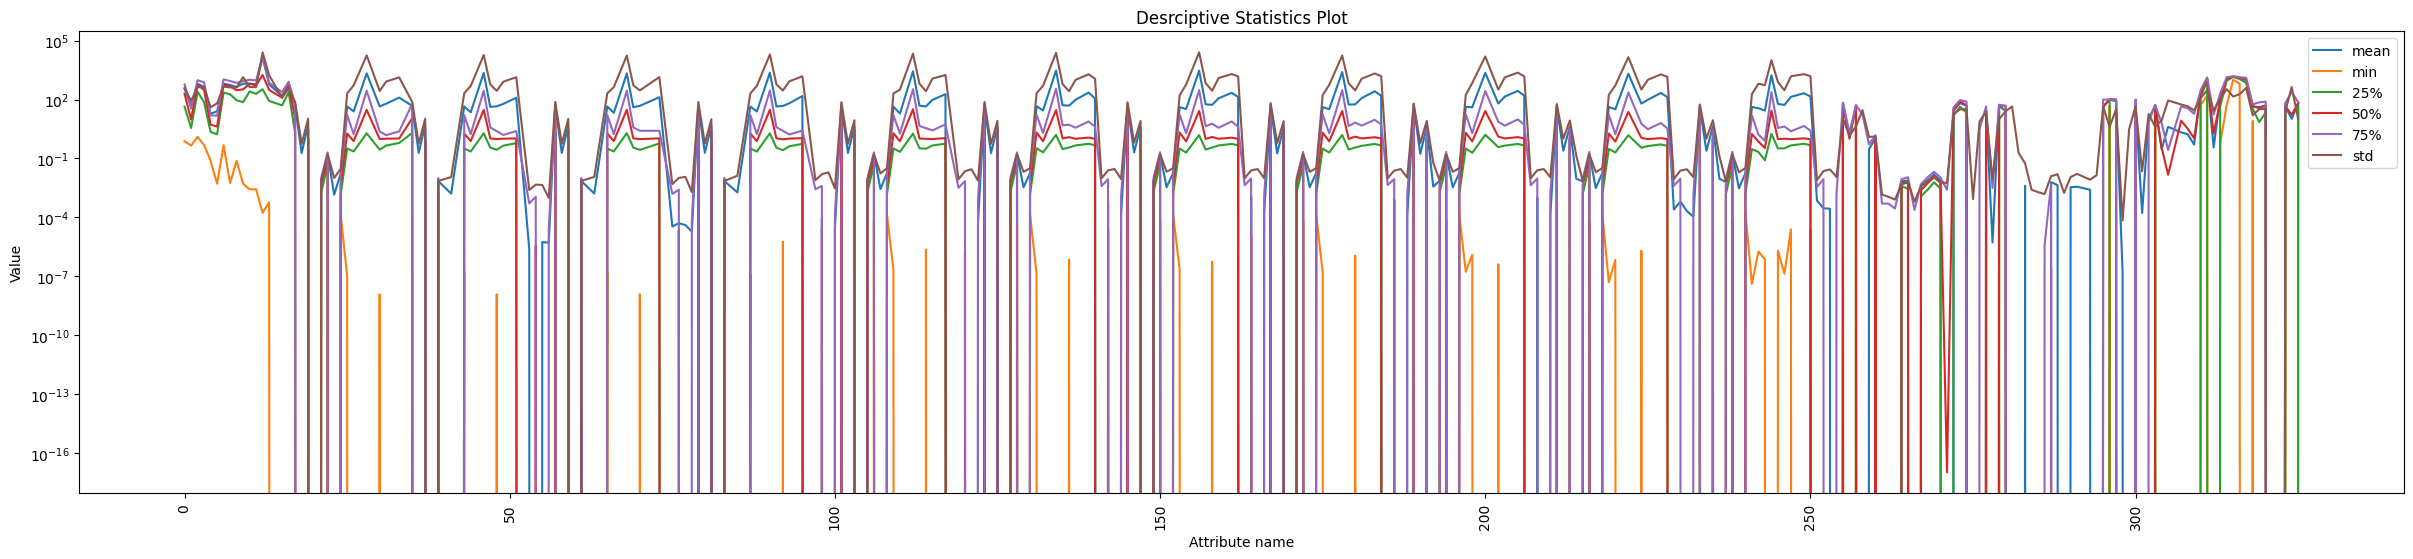

In [54]:
plot_multiple_lines(
    data=df_stats_t,
    x_col=list(df_stats_t.index),
    y_cols=list(df_stats_t.columns),
    title="Desrciptive Statistics Plot",
    xlabel="Attribute name",
    ylabel="Value",
    rotation=90,
)

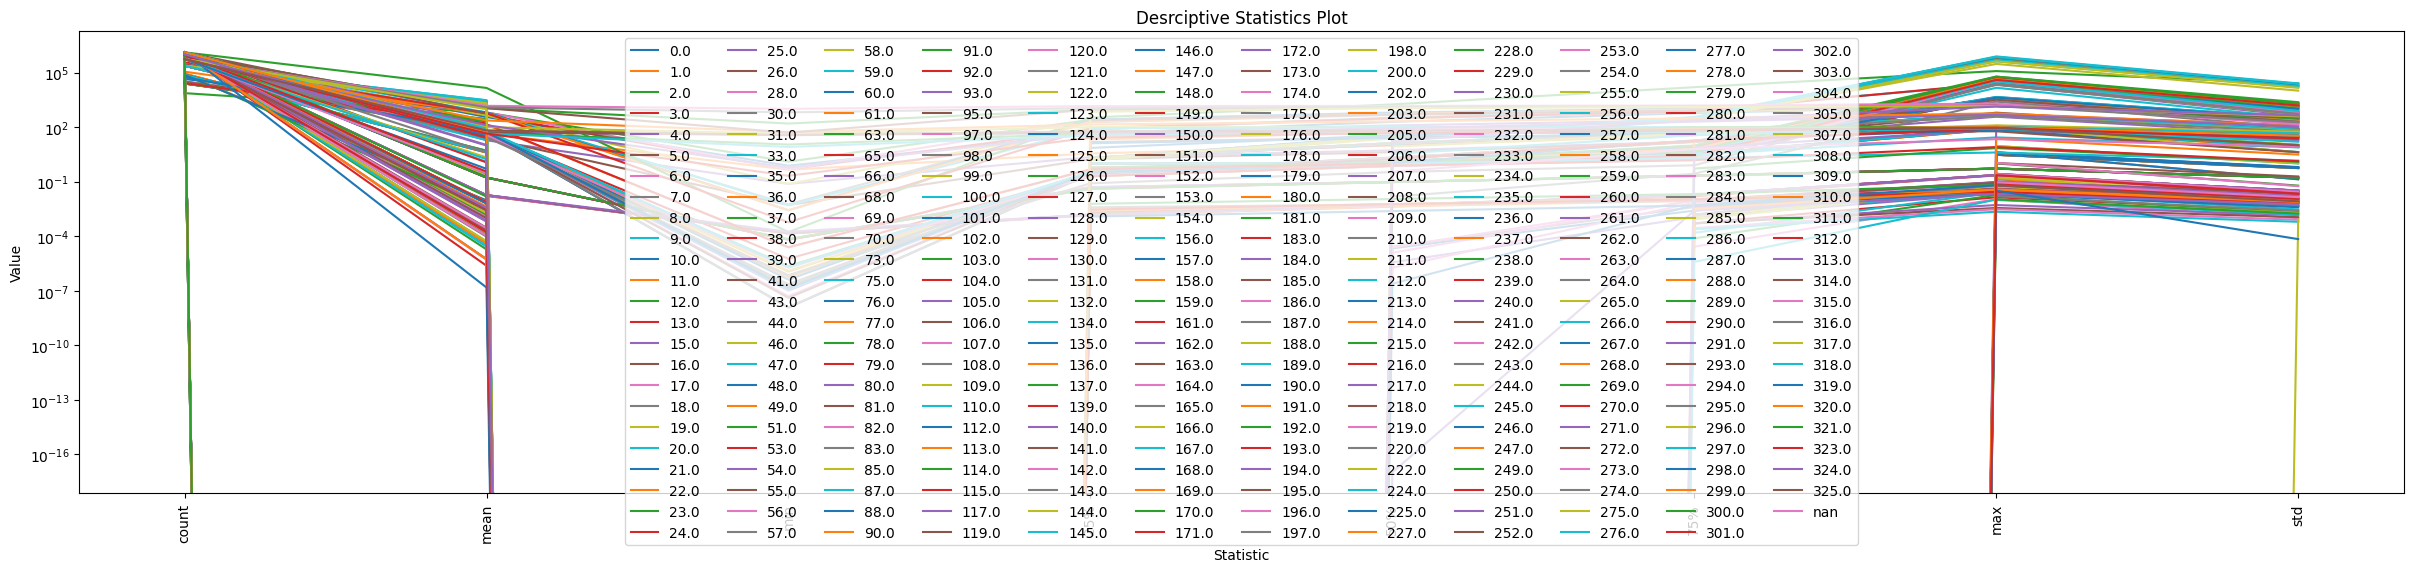

In [64]:
plot_multiple_lines(
    data=df_stats.drop(columns=[col for col in df_stats.columns if pd.isna(col)], axis=1),
    x_col=list(df_stats.index),
    y_cols=list(df_stats.columns),
    title="Desrciptive Statistics Plot",
    xlabel="Statistic",
    ylabel="Value",
    rotation=90,
)

In [18]:
df_numeric = df_clean0.select_dtypes(include=["number"])
new_column_names2 = {col: extract_number(col) for col in df_numeric.columns}
df_numeric.rename(columns=new_column_names2, inplace=True)
correlation = df_numeric.corr()

<Figure size 5000x3000 with 0 Axes>

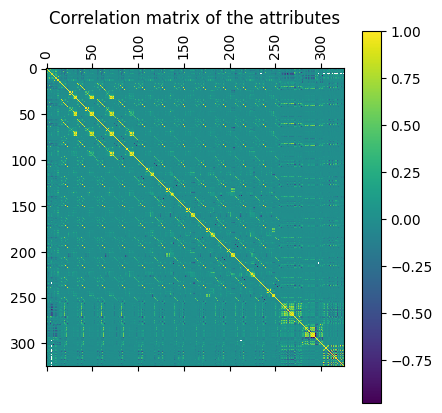

In [8]:
# Create heatmap
plt.figure(figsize=(50, 30))
plt.matshow(correlation)
# Add colorbar
plt.colorbar()
plt.title("Correlation matrix of the attributes")
# Set labels for each cell (optional)
# for i in range(len(correlation.columns)):
#   for j in range(len(correlation.columns)):
#     plt.text(i, j, f"{correlation.iloc[i, j]:.2f}", ha='center', va='center')

# Set ticks and labels for axes
plt.xticks(rotation=90)
plt.show()

In [42]:
# Create a mask to ignore the upper triangle and diagonal elements
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Use the mask to set the upper triangle and diagonal to NaN
tri_df = correlation.mask(mask)

# Find columns with correlation greater than 0.99
highly_correlated_pairs = tri_df[tri_df > 0.99].stack().reset_index()
highly_correlated_pairs.columns = ["Column1", "Column2", "Correlation"]

Columns with correlation greater than 0.99: {'col_225_numeric', 'col_62_numeric', 'col_89_numeric', 'col_27_numeric', 'col_64_numeric', 'col_306_numeric', 'col_26_numeric', 'col_160_numeric', 'col_303_numeric', 'col_31_numeric', 'col_322_numeric', 'col_40_numeric', 'col_248_numeric', 'col_159_numeric', 'col_42_numeric', 'col_204_numeric', 'col_50_numeric', 'col_201_numeric', 'col_155_numeric', 'col_45_numeric', 'col_203_numeric', 'col_182_numeric', 'col_115_numeric', 'col_94_numeric', 'col_181_numeric', 'col_133_numeric', 'col_84_numeric', 'col_86_numeric', 'col_44_numeric', 'col_220_numeric', 'col_29_numeric', 'col_290_numeric', 'col_154_numeric', 'col_223_numeric', 'col_49_numeric', 'col_93_numeric', 'col_66_numeric', 'col_32_numeric', 'col_138_numeric', 'col_52_numeric', 'col_132_numeric', 'col_221_numeric', 'col_71_numeric', 'col_22_numeric', 'col_110_numeric', 'col_176_numeric', 'col_24_numeric', 'col_247_numeric', 'col_226_numeric', 'col_137_numeric', 'col_305_numeric', 'col_198_

In [51]:
corr_columns_drop = list(set(highly_correlated_pairs["Column1"]))
df_clean1 = df_clean0.drop(corr_columns_drop, axis=1)

In [53]:
df_clean1.to_parquet("data_clean1.parquet", engine="pyarrow")

In [5]:
# Define the path to your Parquet file or directory
dataPath2 = "data_clean1.parquet"  
# Read the Parquet data into a DataFrame
df2 = pd.read_parquet(dataPath2)

In [14]:
# Replace outliers with 0.95 quantiles
# Calculate z-scores
is_numeric = df2.select_dtypes(include=[np.number])
z_scores = (is_numeric - is_numeric.mean())/is_numeric.std()

# Identify outliers
outliers = (z_scores > 3) | (z_scores < -3)


In [15]:

# Replace outliers with max/min values (adjust quantiles as needed)
is_numeric[outliers] = np.where(is_numeric[outliers] > is_numeric.quantile(0.95), is_numeric.quantile(0.95),
                      np.where(is_numeric[outliers] < is_numeric.quantile(0.05), is_numeric.quantile(0.05), is_numeric[outliers]))

<Axes: >

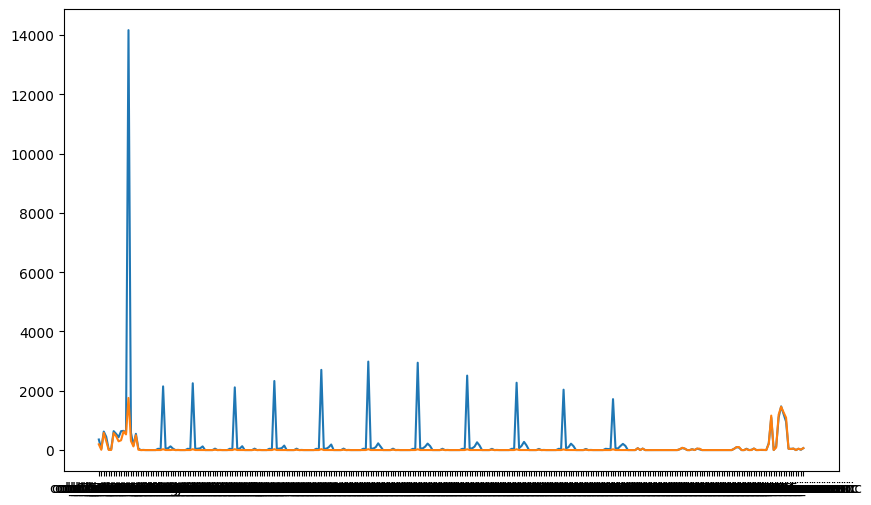

In [20]:
# Analyse what strategy to use for imputing
plt.figure(figsize=(10, 6))
sns.lineplot(is_numeric.mean())
sns.lineplot(is_numeric.median())

In [19]:
is_numeric.mean().describe()

count      286.000000
mean       209.432053
std        959.688539
min         -1.655719
25%          0.002036
50%          4.036090
75%         51.002216
max      14165.277233
dtype: float64

In [21]:
df_clean2 = is_numeric.join(df2.select_dtypes(exclude=[np.number]))
df_clean2.to_parquet("data_clean2.parquet", engine="pyarrow")

In [22]:
df_clean2.head()

,col_0_numeric,col_1_numeric,col_2_numeric,col_3_numeric,col_4_numeric,col_5_numeric,col_6_numeric,col_7_numeric,col_8_numeric,col_9_numeric,...,col_318_numeric,col_319_numeric,col_320_numeric,col_321_numeric,col_323_numeric,col_324_numeric,col_325_numeric,col_14_other,label,timestamp_rounded
0,270.983551,40.060154,NaN,NaN,0.476529,0.131972,NaN,NaN,NaN,NaN,...,NaN,21.428572,7.142857,0.0,NaN,258.870544,NaN,ap-south-1,Continue,2024-04-28 02:04:00
1,NaN,7.867676,NaN,NaN,17.629303,26.530045,NaN,NaN,NaN,NaN,...,64.812294,85.714287,78.571426,0.0,80.260124,-151.599518,53.983444,us-west-2,Continue,2024-04-28 02:13:00
2,NaN,7.867676,NaN,NaN,17.629303,26.530045,NaN,NaN,25.218269,96.353047,...,64.812294,85.714287,78.571426,0.0,80.260124,-151.599518,53.983444,us-west-2,Continue,2024-04-28 02:13:00
3,NaN,7.867676,NaN,NaN,17.629303,26.530045,NaN,NaN,828.416504,1989.064141,...,64.812294,85.714287,78.571426,0.0,80.260124,-151.599518,53.983444,us-west-2,Continue,2024-04-28 02:13:00
4,NaN,7.867676,NaN,NaN,17.629303,26.530045,NaN,NaN,71.380898,300.839694,...,64.812294,85.714287,78.571426,0.0,80.260124,-151.599518,53.983444,us-west-2,Continue,2024-04-28 02:13:00


## Findings

- The data set is an event table where event is continious or interrapted connection. Most of the attributes in the data set are numeric type. The ones which are not numeric are:
    - datetime of an event. This attribute was rounded to minutes to remove duplicates by relevant subset.
    - 2 integer type attributes which might represend indication of different users or/and virtual machines, etc.
    - time zone attribute.
    - all other (over 300) attributes are float type. 

- Data cleaning. Data was cleaned by rounding timestamps to minutes and removing dublicated rows by subset of categorical attributes since the mail goal is to predict interrupted connections so intteruption and event before intterption should be the most valuable.
- Correlation across the columns. There was checked if there are identical columns in dataset and the correlation between them. As you can se from Descriptive statistics plot, there are some replicated patterns in attributes statistics. 
Besides, there no duplicated collumns in the dataset (as it looks like for the first sight), however, some collumns have very high or even perfect correlation equal to 1. This indicates multicollinearity which is problem for model explainability(for Logistic regression model). Around 40 columns were removed from the dataset due to high correlation (over 0.99).

- Missing values. There are a lot of missing values in dataset, some attributes reaching over 99% of missings. The differences across missing values by event type is analysed to check if some missing values can be related to event type, like interruption.
The results are showing that there are different distributions in missing values between event type, but any column had missing values just in one category. From descriptive statistics analysis, there is observed that the direffences between mean and median are quite huge for some attributtes even after outliers replacement with less extreme values. Due to that reason, meadian is selected as a value for missings imputing.
- Data balanse. The dataset is highly inbalance be event time. The interruptions consist 1.4% of original dataset and 6.4% of cleaned dataset. This suggest that data balancing techniques should be used while modeling.
- Outliers were replaced by less extreme values, 0.95 and 0.05 percentiles. Even after the hanling of outliers, we can se that the data is asymetric by the difference between average and median values.